In [2]:
import requests
import time
import re
from bs4 import BeautifulSoup
from bs4 import UnicodeDammit
import http.cookiejar
import os 
import sys
import ijson
import io
from bson.code import Code
import json
import string
from datetime import datetime
from nltk.corpus import stopwords
from datetime import datetime
import re 
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime
import re 
import pandas as pd
from pandas import DataFrame
import random
import numpy as np

## Parse and get the content of the news from the directory 

In [3]:
#a typical leftover thing : [<time class="timestamp__date" datetime="">Feb 13, 2020 7:47AM EST</time>]

In [4]:
paragraph_list=[]
date_list=[]
directory = os.getcwd() #get the local directory where the html file of news are 
for filename in os.listdir(directory):
    paragraph=""
    if filename.endswith('.htm') == False:
        continue
    try:
        with open(os.path.join(directory, filename), 'r',encoding="utf-8") as file:
            text = file.read()
            soup = BeautifulSoup(text, 'html.parser') 
            paragraphs = soup.findAll('p') #find paragraph tag 
        if not paragraphs:
            paragraph=None
        else:
            try:
                #datestamp
                datestr=soup.select('time[datetime]')[0]['datetime']
                clean_date=datestr[0:datestr.rfind('-')] #strip out the clean date time
                datetime_object = datetime.strptime(clean_date, '%Y-%m-%dT%H:%M:%S') #get only date 
                date_list.append(datetime_object.date()) 
                for el in paragraphs[1:]: #first <p> label is meaningless
                    if el.text=="The views and opinions expressed herein are the views and opinions of the author and do not necessarily reflect those of Nasdaq, Inc.":
                        break
                    paragraph=paragraph+el.text
                paragraph_list.append(paragraph)
            except:
                #Some news have null time tag 
                datestr=""
               
    except:
        print("file "+filename,sys.exc_info()[0])

In [5]:
##From previous scraping, there are 814 html file 
##but some are skipped bcs they don't have datetime stamp 
##This is to see if paragraph and date has maching number of items as they will be put into key-value pair in a dictionary later
print('There are ',len(paragraph_list),'paragraphs and',len(date_list),'date stamps')

There are  806 paragraphs and 806 date stamps


In [6]:
date_parag_pair=dict()
for pa in paragraph_list:
    i=paragraph_list.index(pa)
    date_parag_pair[date_list[i]]=pa
    
#choose a random sample to check
print(random.sample(date_parag_pair.items(),1)) 

[(datetime.date(2020, 2, 2), "China's top electric vehicle battery maker CATL said on Monday it has signed a battery supply agreement with Tesla.Adds background on TeslaSHANGHAI, Feb 3 (Reuters) - China's top electric vehicle battery maker CATL 300750.SZ said on Monday it has signed a battery supply agreement with Tesla TSLA.O.Tesla will determine the battery purchase volume between July 2020 and June 2022, according to its own needs, CATL said in a stock exchange filing, adding the agreement does not impose restrictions on Tesla's purchase volume.Tesla, which has a long-standing battery supply agreement with Japan's Panasonic Corp 6752.T, said during its earnings call last week that its pact with LG Chem 051910.KS and CATL was at a smaller scale.Tesla is building Model 3 vehicles from its $2 billion Shanghai factory, which started delivering cars last year, and has said it would diversify battery supplies for the plant.(Reporting by Yilei Sun and Brenda Goh; Editing by Kim Coghill and

## Sentiment Analysis

In [70]:
sums=[]
date_sentim_pair=dict()
for pa in paragraph_list:
    sum=0
    blob=TextBlob(pa)
    for sentence in blob.sentences:
        sentim=sentence.sentiment.polarity
        sum=sum+sentim
    i=paragraph_list.index(pa)
    sentim_avg=sum/len(blob.sentences) #sum of sentiment of a news paragraph devided by length of sentiment
    #average sentiment of a news 
    date_sentim_pair[date_list[i]]=sentim_avg
#use the last one pair for format checking
print(date_list[i])
print(sentim_avg)



2019-10-24
0.33754947433518856


## Plots

#### Sentiment Plot

In [20]:
sentim=pd.DataFrame(date_sentim_pair.items())
sentim.rename(columns={0:"Date",1:"Sentiment"},inplace=True)
sentim=sentim.sort_values(by=['Date'])
sentim.head()

Date  Sentiment
85  2019-10-01   0.050053
7   2019-10-02   0.000617
10  2019-10-03   0.186295
25  2019-10-04   0.037832
94  2019-10-05   0.187161

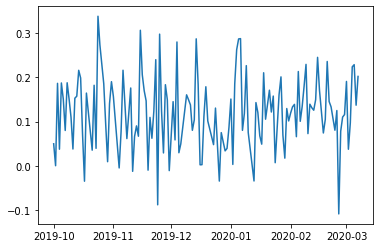

In [22]:
plt.plot("Date","Sentiment",data=sentim)

#### Stock price plot

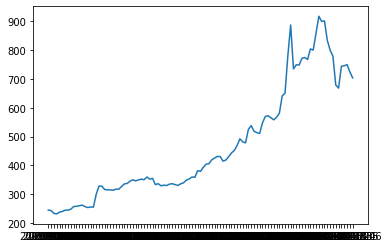

In [23]:
price=pd.read_csv('TSLA.csv') #Tesla data downloaded from Yahoo Finance
price_date=price['Date']
price_close=price['Close']
plt.plot('Date','Close',data=price)
plt.show()

## Merging sentiment with stock price for ML modeling

In [24]:
sentim.Date= pd.to_datetime(sentim.Date)
price.Date = pd.to_datetime(price.Date)
##merge news sentiment with price 
date_sentim_price = pd.merge(sentim,
                 price,
                 on='Date',how='right')
date_sentim_price=date_sentim_price.sort_values('Date')
date_sentim_price=date_sentim_price.fillna(0) #fillna so that all the days with price has sentim
date_sentim_price.head()

Date  Sentiment        Open        High         Low       Close  \
0 2019-10-01   0.050053  241.500000  245.949997  239.130005  244.690002   
1 2019-10-02   0.000617  243.289993  244.649994  239.429993  243.130005   
2 2019-10-03   0.186295  231.860001  234.479996  224.279999  233.029999   
3 2019-10-04   0.037832  231.610001  234.779999  228.070007  231.429993   
4 2019-10-07   0.080072  229.800003  238.559998  228.550003  237.720001   

    Adj Close    Volume  
0  244.690002   6162600  
1  243.130005   5631400  
2  233.029999  15084500  
3  231.429993   7995000  
4  237.720001   8064200

####  OPtional: adding twitter sentiment scraped from another project, which results in higher accuracy

In [25]:
##prepare twitter data 
twit=pd.read_csv('tweets_sentim_avg.csv')
twit_sentim=pd.DataFrame(twit[['date','retweet_count','num_tweets','avg_sentiment']])
twit_sentim.rename(columns={'date':"Date","avg_sentiment":"Twit_sentim_avg"},inplace=True)
twit_sentim.head()

Date  retweet_count  num_tweets  Twit_sentim_avg
0  10/14/19             55          41         -0.00763
1  10/15/19              1          13          0.04002
2  10/16/19              5           4          0.13906
3  10/17/19              4           6          0.07273
4  10/18/19              0           1          0.37879

In [28]:
twit_sentim.Date= pd.to_datetime(twit_sentim.Date)
##merge twit sentiment with news sentiment and  price 
date_2sentim_price = pd.merge(date_sentim_price,
                 twit_sentim,
                 on='Date',how='left')
date_2sentim_price=date_2sentim_price.sort_values('Date') #sort date 
date_2sentim_price.rename(columns={'Sentiment':'News_Sentim_avg'},inplace=True)
#date_2sentim_price[date_2sentim_price.isna().any(axis=1)] # to see about null values 
date_2sentim_price=date_2sentim_price.fillna(0)
date_2sentim_price['Sentiment_newstwit']=date_2sentim_price['News_Sentim_avg']+date_2sentim_price['Twit_sentim_avg']
date_2sentim_price.head()

Date  News_Sentim_avg        Open        High         Low       Close  \
0 2019-10-01         0.050053  241.500000  245.949997  239.130005  244.690002   
1 2019-10-02         0.000617  243.289993  244.649994  239.429993  243.130005   
2 2019-10-03         0.186295  231.860001  234.479996  224.279999  233.029999   
3 2019-10-04         0.037832  231.610001  234.779999  228.070007  231.429993   
4 2019-10-07         0.080072  229.800003  238.559998  228.550003  237.720001   

    Adj Close    Volume  retweet_count  num_tweets  Twit_sentim_avg  \
0  244.690002   6162600            0.0         0.0              0.0   
1  243.130005   5631400            0.0         0.0              0.0   
2  233.029999  15084500            0.0         0.0              0.0   
3  231.429993   7995000            0.0         0.0              0.0   
4  237.720001   8064200            0.0         0.0              0.0   

   Sentiment_newstwit  
0            0.050053  
1            0.000617  
2            0.186295  
3            0.037832  
4            0.080072

In [29]:
#Count proportion of positive news and negative news 

print("Percentage of positive news:",round(date_2sentim_price[date_2sentim_price.News_Sentim_avg>0].count()['Date']/len(date_2sentim_price)*100,2),'%')
print("Percentage of negative news:",round(date_2sentim_price[date_2sentim_price.News_Sentim_avg<0].count()['Date']/len(date_2sentim_price)*100,2),'%')
print("Percentage of neutral news or no news:",round(date_2sentim_price[date_2sentim_price.News_Sentim_avg==0].count()['Date']/len(date_2sentim_price)*100,2),'%')

Percentage of positive news: 92.66 %
Percentage of negative news: 6.42 %
Percentage of neutral news or no news: 0.92 %


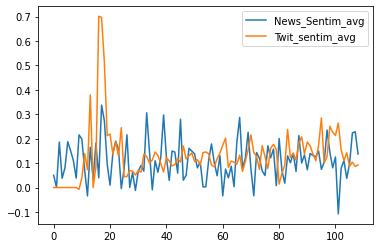

In [30]:
#plot of two sentiment 
plt.plot("News_Sentim_avg",data=date_2sentim_price)
plt.plot("Twit_sentim_avg",data=date_2sentim_price)
plt.legend()
plt.show()

## Correlation Inspection 

In [31]:
#news+twit sentiment vs close price 
np.corrcoef(date_2sentim_price['Close'],date_2sentim_price['Sentiment_newstwit'])

array([[1.        , 0.12986512],
       [0.12986512, 1.        ]])

### Regression sentiment vs lag1 price 

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [35]:
##function to change stock price change percentage into an indicator from 1-5 for classification model
## used a box plot to see the price change percentage range. 0.15 is the number. 
def pct_label(x):
    if x<=-0.15:
        return 0
    elif x >-0.15 and x<=-0.05:
        return 1
    elif x>-0.05 and x<0:
        return 2
    elif x==0:
        return 3
    elif x>0.05 and x<=0.15:
        return 4
    elif x>0.15:
        return 5
    else:
        return 0 


In [36]:
date_2sentim_price.head(1)

Date  News_Sentim_avg   Open        High         Low       Close  \
0 2019-10-01         0.050053  241.5  245.949997  239.130005  244.690002   

    Adj Close   Volume  retweet_count  num_tweets  Twit_sentim_avg  \
0  244.690002  6162600            0.0         0.0              0.0   

   Sentiment_newstwit  
0            0.050053

In [37]:
#fewer number of unnecessary columns
regres_data=date_2sentim_price.drop(["Open","High","Low","Volume"],axis=1)
regres_data.head()

Date  News_Sentim_avg       Close   Adj Close  retweet_count  \
0 2019-10-01         0.050053  244.690002  244.690002            0.0   
1 2019-10-02         0.000617  243.130005  243.130005            0.0   
2 2019-10-03         0.186295  233.029999  233.029999            0.0   
3 2019-10-04         0.037832  231.429993  231.429993            0.0   
4 2019-10-07         0.080072  237.720001  237.720001            0.0   

   num_tweets  Twit_sentim_avg  Sentiment_newstwit  
0         0.0              0.0            0.050053  
1         0.0              0.0            0.000617  
2         0.0              0.0            0.186295  
3         0.0              0.0            0.037832  
4         0.0              0.0            0.080072

In [38]:
regres_data['Diff_pct']=regres_data['Close'].diff(-1)/regres_data['Close']
regres_data.head()

Date  News_Sentim_avg       Close   Adj Close  retweet_count  \
0 2019-10-01         0.050053  244.690002  244.690002            0.0   
1 2019-10-02         0.000617  243.130005  243.130005            0.0   
2 2019-10-03         0.186295  233.029999  233.029999            0.0   
3 2019-10-04         0.037832  231.429993  231.429993            0.0   
4 2019-10-07         0.080072  237.720001  237.720001            0.0   

   num_tweets  Twit_sentim_avg  Sentiment_newstwit  Diff_pct  
0         0.0              0.0            0.050053  0.006375  
1         0.0              0.0            0.000617  0.041542  
2         0.0              0.0            0.186295  0.006866  
3         0.0              0.0            0.037832 -0.027179  
4         0.0              0.0            0.080072 -0.009801

In [39]:
#use diff 
regres_data['Diff_pct_lag1']=regres_data['Diff_pct'].shift(-1)
#tried out other lags, lag 1 makes the most sense. 
# regres_data['Price_lag2']=regres_data['Diff'].shift(-2)
# regres_data['Price_lag3']=regres_data['Diff'].shift(-3)
# regres_data['Price_lag4']=regres_data['Diff'].shift(-4)
# regres_data['Price_lag5']=regres_data['Diff'].shift(-5)
# regres_data['Price_lag6']=regres_data['Diff'].shift(-6)
# regres_data['Price_lag7']=regres_data['Close'].shift(-7)
regres_data.dropna(inplace=True)
regres_data.head()

Date  News_Sentim_avg       Close   Adj Close  retweet_count  \
0 2019-10-01         0.050053  244.690002  244.690002            0.0   
1 2019-10-02         0.000617  243.130005  243.130005            0.0   
2 2019-10-03         0.186295  233.029999  233.029999            0.0   
3 2019-10-04         0.037832  231.429993  231.429993            0.0   
4 2019-10-07         0.080072  237.720001  237.720001            0.0   

   num_tweets  Twit_sentim_avg  Sentiment_newstwit  Diff_pct  Diff_pct_lag1  
0         0.0              0.0            0.050053  0.006375       0.041542  
1         0.0              0.0            0.000617  0.041542       0.006866  
2         0.0              0.0            0.186295  0.006866      -0.027179  
3         0.0              0.0            0.037832 -0.027179      -0.009801  
4         0.0              0.0            0.080072 -0.009801      -0.018663

In [40]:
linear_model = LinearRegression() 
X=regres_data[['News_Sentim_avg','Twit_sentim_avg','retweet_count','num_tweets']]
#X=regres_data.loc[:,'retweet_count':'Sentiment_added']
y=regres_data['Diff_pct_lag1'].apply(pct_label)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
reg_1 = LogisticRegression().fit(X_train, y_train)
reg_1.score(X_test, y_test)

C:\Users\49224\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5454545454545454

## Bonus: word cloud

In [41]:
import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
from wordcloud import WordCloud, STOPWORDS

In [42]:
len(paragraph_list)

806

In [43]:
warnings.filterwarnings(action = 'ignore') 
#  Reads  file 
#s = paragraph_list[0]
stop_words = stopwords.words('english')
# Replaces escape character with space 
datas=[]
for s in paragraph_list:
    f = s.replace("\n", " ") 
    data = [] 
    for i in sent_tokenize(f): 
        temp = [] 
        i=i.lower()
        filtered_temptext = [w.strip() for w in word_tokenize(i) if not w.strip() in stop_words]
        nopunc_temptext = [j.translate(str.maketrans('', '', string.punctuation)) for j in filtered_temptext]
        #review_dict_copy[i]=filtered_temptext
        x=[data.append(i) for i in nopunc_temptext]
    datas.append(data)
wordcloud_data=pd.DataFrame(datas)

In [44]:
def word_cloud(df):
    plt.subplots(figsize = (12,10))
    wordcloud = WordCloud(
            background_color = 'white',
            width = 1000,
            height = 800).generate(" ".join(df[0]))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show

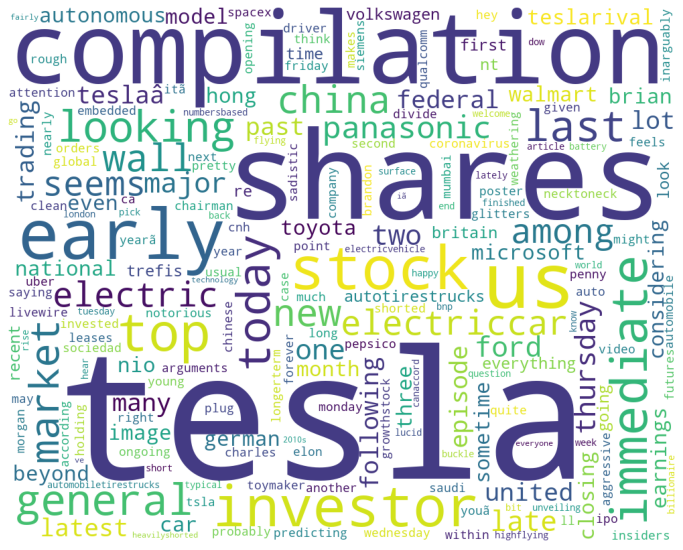

In [45]:
word_cloud(wordcloud_data)

## word2vec (Exploratory, not included in the report)

In [52]:

warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 
  
#  Reads  file 
s = paragraph_list[0]
stop_words = stopwords.words('english')
# Replaces escape character with space 
f = s.replace("\n", " ") 
  
data = [] 
  
# iterate through each sentence in the file 
for i in sent_tokenize(f): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        #temp.append(j.lower()) 
        j=j.lower()
        #symbols = "!\"#$%&()*+-./:,;<=>?@[\]^_`{|}~\n'`"
        ##get rid of stop words and symbols 
        #s.translate(None, string.punctuation)
        filtered_temptext = j.translate(str.maketrans('', '', string.punctuation))
        #review_dict_copy[i]=filtered_temptext
        temp.append(filtered_temptext)
    data.append(temp) 
    
# Create Skip Gram model 
model2 = gensim.models.Word2Vec(data, min_count = 1, size = 100, 
                                             window = 5, sg = 1) 
  
# Print results 
print("Cosine similarity between 'tesla' " +
          "and 'good' - Skip Gram : ", 
    model2.similarity('tesla', 'good')) 
      
# print("Cosine similarity between 'alice' " +
#             "and 'machines' - Skip Gram : ", 
#       model2.similarity('alice', 'machines')) 


Cosine similarity between 'tesla' and 'good' - Skip Gram :  0.9993907


In [53]:
model2.most_similar(positive=['tesla'],negative=['stock'])

[('2', 0.05649084225296974),
 ('michael', 0.029592812061309814),
 ('disclosure', 0.02579793706536293),
 ('critical', 0.02451128512620926),
 ('disappear', 0.023333271965384483),
 ('summarizing', 0.023203667253255844),
 ('date', 0.022879965603351593),
 ('accounts', 0.022761356085538864),
 ('daimler', 0.02152874320745468),
 ('hello', 0.021471094340085983)]

In [54]:
model2.most_similar(positive=['tesla'])

[('most', 0.9996460676193237),
 ('things', 0.9996376037597656),
 ('has', 0.9996244311332703),
 ('spiffy', 0.999615490436554),
 ('like', 0.9996144771575928),
 ('actually', 0.9996127486228943),
 ('back', 0.999604344367981),
 ('thinking', 0.9996026754379272),
 ('my', 0.9995982646942139),
 ('would', 0.9995977878570557)]

## Doc2vec The main NLP mathod

### Prepare the data 

In [57]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize 
import multiprocessing
cores = multiprocessing.cpu_count()
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn import utils
from sklearn.linear_model import LogisticRegression
import nltk
from sklearn.metrics import accuracy_score, f1_score

In [47]:
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [49]:
date_parag_df=pd.DataFrame(date_parag_pair.items())
date_parag_df.rename(columns={0:"Date",1:"paras"},inplace=True)
#date_parag_df=date_parag_df.set_index("Date")
date_parag_df.Date= pd.to_datetime(date_parag_df.Date)
price.Date = pd.to_datetime(price.Date)
##merge 

In [50]:
# date_parag_pair
date_parag_price_df = pd.merge(date_parag_df,
                 price,
                 on='Date',how='right')
len(date_parag_price_df)
date_parag_price_df=date_parag_price_df.fillna("")
# to see whether there is still null values 
date_parag_price_df[date_parag_price_df.isna().any(axis=1)] 

Empty DataFrame
Columns: [Date, paras, Open, High, Low, Close, Adj Close, Volume]
Index: []

In [51]:
len(date_parag_price_df)

109

In [52]:
date_parag_price_df=date_parag_price_df.sort_values('Date')
#date_parag_price_df=date_parag_price_df.sort_values('Date')
date_parag_price_df.head()
date_parag_price_df['diff_pct']=date_parag_price_df['Close'].diff(-1)/date_parag_price_df['Close']
date_parag_price_df['Price_lag1']=date_parag_price_df['diff_pct'].shift(-1)
date_parag_price_df['labels'] = date_parag_price_df['Price_lag1'].apply(pct_label)
regres_data.dropna(inplace=True)
date_parag_price_df.head(3)
#parag_df['label']=np.arange(len(parag_df))
#parag_df.columns={"parag","labels"}
#parag_df.columns={"parag"}
#parag_df.head()

Date                                              paras        Open  \
76 2019-10-01  Tesla Inc's electric Model 3 remained Norway's...  241.500000   
6  2019-10-02  (RTTNews) - Tesla Inc. (TSLA) achieved record ...  243.289993   
9  2019-10-03  Major benchmarks staged a big comeback on Thur...  231.860001   
23 2019-10-04  Shares of China’s electric car company Nio (NY...  231.610001   
0  2019-10-07  PepsiCo (NASDAQ:) is planning to adopt Tesla (...  229.800003   

          High         Low       Close   Adj Close    Volume  diff_pct  \
76  245.949997  239.130005  244.690002  244.690002   6162600  0.006375   
6   244.649994  239.429993  243.130005  243.130005   5631400  0.041542   
9   234.479996  224.279999  233.029999  233.029999  15084500  0.006866   
23  234.779999  228.070007  231.429993  231.429993   7995000 -0.027179   
0   238.559998  228.550003  237.720001  237.720001   8064200 -0.009801   

    Price_lag1  labels  
76    0.041542       0  
6     0.006866       0  
9    -0.027179       2  
23   -0.009801       2  
0    -0.018663       2

In [53]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [54]:
train, test = train_test_split(date_parag_price_df, test_size=0.3, random_state=42)
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['paras']), tags=[r.labels]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['paras']), tags=[r.labels]), axis=1)

In [55]:
train_tagged.values[30]

TaggedDocument(words=['shares', 'of', 'tesla', 'nasdaq', 'tsla', 'jumped', 'on', 'thursday', 'rising', 'as', 'much', 'as', '19.7', 'as', 'of', '11:47', 'a.m.', 'edt', 'the', 'stock', 'was', 'up', '16.6', '.the', 'stock', "'s", 'gain', 'follows', 'the', 'company', "'s", 'third-quarter', 'results', 'which', 'featured', 'surprising', 'profit', 'in', 'addition', 'the', 'company', "'s", 'free', 'cash', 'flow', 'was', 'much', 'higher', 'than', 'anticipated.image', 'source', 'getty', 'images.in', 'its', 'third', 'quarter', 'the', 'electric-car', 'company', 'reported', 'non-gaap', 'adjusted', 'earnings', 'per', 'share', 'of', '1.86', '--', 'well', 'ahead', 'of', 'an', 'average', 'analyst', 'estimate', 'for', 'loss', 'per', 'share', 'of', '0.42', 'free', 'cash', 'flow', 'similarly', 'crushed', 'analyst', 'estimates', 'coming', 'in', 'at', '371', 'million', 'on', 'average', 'analysts', 'had', 'expected', 'tesla', 'to', 'report', 'free', 'cash', 'flow', 'of', '32', 'million', 'another', 'quarter'

### 1st Doc2vec Model: DBOW Model

In [58]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 76/76 [00:00<?, ?it/s]


In [59]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 76/76 [00:00<?, ?it/s]


Wall time: 1.1 s


In [60]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [61]:
len(X_train)

85

In [68]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5757575757575758
Testing F1 score: 0.553939393939394


### 2nd Model: DM Model

In [64]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 76/76 [00:00<?, ?it/s]


In [65]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 76/76 [00:00<?, ?it/s]


Wall time: 2.01 s


In [67]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.45454545454545453
Testing F1 score: 0.39212779973649536
